In [12]:
from wfdb.io import rdrecord
import matplotlib.pyplot as plt

In [6]:
record=rdrecord('processed1/JS00001')
recordHC=rdrecord('processed1/JS00008')




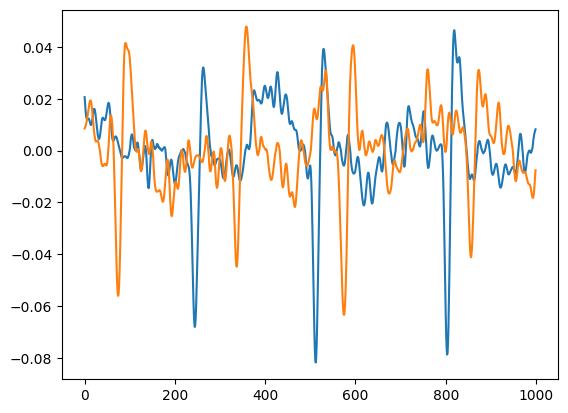

In [59]:
signals=[record.p_signal[x:x+1000] for x in range(0,4000,1000)]
plt.plot(signals[1].T[3])
plt.plot(signals[2].T[3])


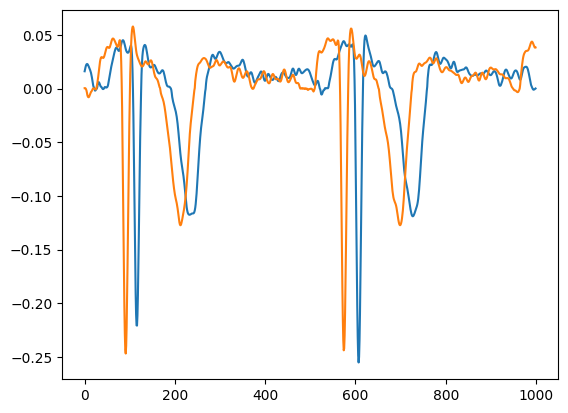

In [60]:
signalsHC=[recordHC.p_signal[x:x+1000] for x in range(0,4000,1000)]
plt.plot(signalsHC[1].T[3])
plt.plot(signalsHC[2].T[3])

In [85]:
import numpy as np
import pydmd as dmd

def AugMat(signal: np.ndarray, h: int):
    print(signal.shape)
    n, m = signal.shape
    aug = []
    for i in range(n):
        for x in range(h):
            row = signal[i][x:m-h+x]
            aug.append(row)
    return np.vstack(aug)
def extract(signal:np.ndarray):

    
    # Get the signals augumented
    signal=AugMat(signal.T,200)


    #fit the DMD model
    DMD=dmd.DMD()
    DMD.fit(signal)

    #get the eigenvalue and vectors
    eigs=DMD.eigs
    modes=DMD.modes

    #restack the modes to match the 12 leads
    restacked= modes.reshape(12, 200, -1).mean(axis=1)

    #get lambda U for unstable S for stable
    Lambda_ind_u = np.where(np.abs(eigs) > 1)
    Lambda_ind_s = np.where(np.abs(eigs) < 1)

    Lambda_u = eigs[Lambda_ind_u] #unstable eigen values
    Lambda_s = eigs[Lambda_ind_s] #stable eigen values

    # Get the eigenvectors off the eigenvalue indexes
    Pho_u = restacked[:,Lambda_ind_u].reshape((12,Lambda_u.shape[0])) #unstable modes
    Pho_s = restacked[:,Lambda_ind_s].reshape((12,Lambda_s.shape[0])) #stable modes

    #number of Stable and unstable modes
    numS=Lambda_s.shape[0]
    numU=Lambda_u.shape[0]

    # unstable to stable DM ratio
    R_N=(numU)/(numU+numS)

    #unstable lambda to all
    R_L=np.sum(np.abs(Lambda_u))/(np.sum(np.abs(Lambda_s))+np.sum(np.abs(Lambda_u)))

    R_M = np.sum(np.sum(np.abs(Pho_u), axis = 1))/(np.sum(np.sum(np.abs(Pho_u), axis = 1)) + np.sum(np.sum(np.abs(Pho_s), axis = 1)))
    R_P = np.sum(np.sum(np.angle(Pho_u), axis = 1))/(np.sum(np.sum(np.angle(Pho_u), axis = 1)) +  np.sum(np.sum(np.angle(Pho_s), axis = 1)))


    Lam_min = np.min(np.abs(Lambda_s),initial = -1 )
    Lam_max = np.max(np.abs(Lambda_u), initial = -1 )

    #for unstble modes
    M_u = np.mean(np.abs(Pho_u), axis=1)
    P_u = np.mean(np.angle(Pho_u-np.angle(Pho_u[0])), axis=1)


    #for stable modes
    M_s = np.mean(np.abs(Pho_s), axis=1)
    P_s = np.mean(np.angle(Pho_s-np.angle(Pho_s[0])), axis=1)



    return [ R_N,R_L, R_M, R_P, Lam_min, Lam_max, M_s, P_s, M_u, P_u]


def process(signal:np.ndarray):
    signals=[signal[x:x+1000] for x in range(0,4000,1000)]
    init=extract(signals[0])
    feat=[]
    for i in range(1,len(signals)):
        new=extract(signals[i])
        feat.append([new[x]-init[x] for x in range(len(init))])
        init=new
    return feat





In [87]:
cond=process(record.p_signal)
hc=process(recordHC.p_signal)

(12, 1000)
(12, 1000)


/tmp/ipykernel_18578/1854892649.py:53: RuntimeWarning: invalid value encountered in scalar divide
  R_P = np.sum(np.sum(np.angle(Pho_u), axis = 1))/(np.sum(np.sum(np.angle(Pho_u), axis = 1)) +  np.sum(np.sum(np.angle(Pho_s), axis = 1)))


(12, 1000)
(12, 1000)
(12, 1000)
(12, 1000)
(12, 1000)
(12, 1000)


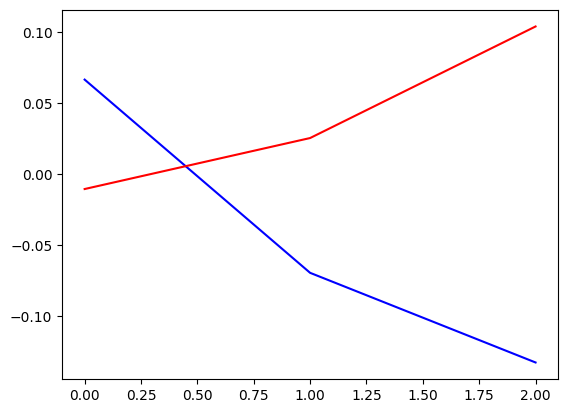